In [1]:
#Import Library
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Load Dataset
df = pd.read_csv("Penjualan warmindo.csv")

In [3]:
#Pra-Pemrosesan Data
print(df.isnull().sum())
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df['nama_produk'] = df['nama_produk'].str.lower().str.strip()

id                   0
invoice_id           0
tanggal_transaksi    0
customer_id          0
nama_produk          0
jenis_produk         0
kategori_produk      0
quantity             0
harga_jual           0
jenis_pembayaran     0
jenis_pesanan        0
nilai_penjualan      0
dtype: int64


In [4]:
#USER-ITEM MATRIX (customer_id vs nama_produk)
user_item_matrix = df.pivot_table(index='customer_id',
                                  columns='nama_produk',
                                  values='quantity',
                                  aggfunc='sum',
                                  fill_value=0)

In [5]:
#ITEM-BASED COLLABORATIVE FILTERING
sparse_matrix = csr_matrix(user_item_matrix.values)
item_sim = cosine_similarity(sparse_matrix.T)
item_sim_df = pd.DataFrame(item_sim,
                           index=user_item_matrix.columns,
                           columns=user_item_matrix.columns)

In [6]:
#Fungsi Rekomendasi Produk (Item-Based)
def rekomendasi_produk(nama_produk, top_n=5):
    if nama_produk not in item_sim_df.columns:
        return f"Produk '{nama_produk}' tidak ditemukan."
    similar_scores = item_sim_df[nama_produk].sort_values(ascending=False)
    rekomendasi = similar_scores.iloc[1:top_n+1]
    return rekomendasi

In [7]:
#HEATMAP KEMIRIPAN ANTAR PRODUK (TOP 10 PRODUK)
def tampilkan_heatmap(top_k=10):
    top_items = df['nama_produk'].value_counts().head(top_k).index.tolist()
    similarity_subset = item_sim_df.loc[top_items, top_items]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_subset, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Heatmap Kemiripan Antar Produk")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [8]:
#USER-BASED COLLABORATIVE FILTERING
user_sim = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim,
                           index=user_item_matrix.index,
                           columns=user_item_matrix.index)

def rekomendasi_berdasarkan_user(user_id, top_n=5):
    if user_id not in user_item_matrix.index:
        return f"Pelanggan dengan ID {user_id} tidak ditemukan."
    
    similar_users = user_sim_df[user_id].sort_values(ascending=False).iloc[1:]
    similar_user_id = similar_users.index[0]

    user_produk = user_item_matrix.loc[user_id]
    similar_user_produk = user_item_matrix.loc[similar_user_id]

    rekomendasi_produk = similar_user_produk[user_produk == 0].sort_values(ascending=False).head(top_n)
    return rekomendasi_produk


 Rekomendasi menu mirip dengan 'Indomie Ayam Spesial':
Produk 'Indomie Ayam Spesial' tidak ditemukan.

 Menampilkan heatmap kemiripan produk...


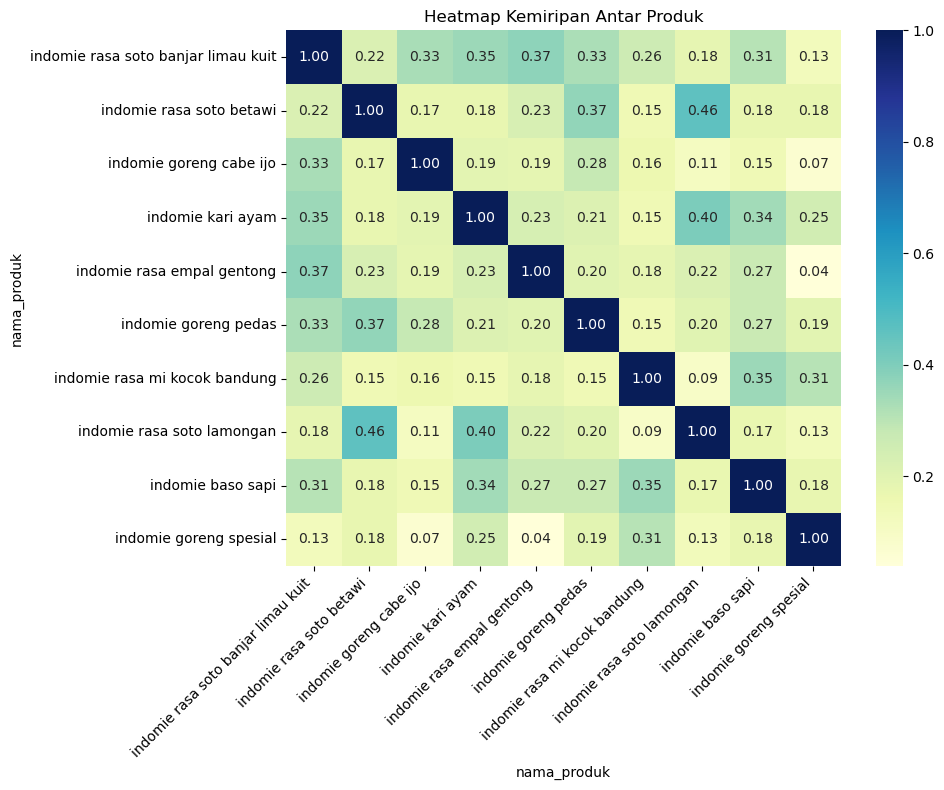


 Rekomendasi untuk user dengan ID 44:
nama_produk
indomie rasa soto padang    2
indomie ayam bawang         1
indomie kari ayam           1
indomie baso sapi           0
indomie goreng aceh         0
Name: 60, dtype: int64


In [9]:
#Example
#  Rekomendasi berdasarkan produk
produk_input = "Indomie Ayam Spesial"
print(f"\n Rekomendasi menu mirip dengan '{produk_input}':")
print(rekomendasi_produk(produk_input, top_n=5))

#  Heatmap kemiripan
print("\n Menampilkan heatmap kemiripan produk...")
tampilkan_heatmap()

#  Rekomendasi berdasarkan user
user_input = 44  # ganti sesuai ID customer yang ada
print(f"\n Rekomendasi untuk user dengan ID {user_input}:")
print(rekomendasi_berdasarkan_user(user_input, top_n=5))

In [10]:
# Fungsi prediksi item-based untuk seluruh matrix
def prediksi_item_based(matrix, similarity):
    pred = np.zeros(matrix.shape)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            sim_scores = similarity[j]
            user_ratings = matrix.iloc[i].values
            mask = user_ratings > 0
            if np.sum(sim_scores[mask]) > 0:
                pred[i, j] = np.dot(sim_scores[mask], user_ratings[mask]) / np.sum(sim_scores[mask])
    return pred

# Hitung prediksi dan MAE
prediksi_rating = prediksi_item_based(user_item_matrix, item_sim)
aktual = user_item_matrix.values[user_item_matrix.values > 0]
prediksi = prediksi_rating[user_item_matrix.values > 0]

mae = mean_absolute_error(aktual, prediksi)
print(f"\nNilai Mean Absolute Error (MAE) model rekomendasi: {mae:.4f}")


Nilai Mean Absolute Error (MAE) model rekomendasi: 0.4361
